In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import platform
import pathlib  
import os.path
#!pip install netCDF4 h5netcdf
import cartopy



In [36]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'Sattelite')
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')

print(f"Welcome {username}, have a wondeful day on your {OS_type} machine. Your data should be located in {data_path}")

Welcome Mootje, have a wondeful day on your Windows machine. Your data should be located in C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Satellite


In [37]:
data_files = glob.glob(os.path.join(data_path, '*.nc'))

datasets = {}

for file_path in data_files:
    # Extract the file identifier from the file name
    file_name = os.path.basename(file_path)  # Get just the file name
    file_identifier = file_name.split('_')[0]  # Split by underscore and take the first part
    # print(file_identifier)
    # Open the dataset
    dataset = xr.open_dataset(file_path)
    # print(dataset)
    # Add the file identifier as a new coordinate
    dataset = dataset.assign_coords(file_identifier=file_identifier)
    
    # Add the dataset to the dictionary with the file identifier as the key
    datasets[file_identifier] = dataset
    # print(datasets[file_identifier])

In [38]:
chirps = datasets['chirps']
chirps

<xarray.Dataset> Size: 463MB
Dimensions:          (latitude: 210, longitude: 302, time: 1826)
Coordinates:
  * latitude         (latitude) float32 840B -5.025 -4.975 ... 5.375 5.425
  * longitude        (longitude) float32 1kB 28.47 28.52 28.57 ... 43.47 43.52
  * time             (time) datetime64[ns] 15kB 2018-01-01 ... 2022-12-31
    file_identifier  <U6 24B 'chirps'
Data variables:
    precip           (time, latitude, longitude) float32 463MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2019-01-30
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

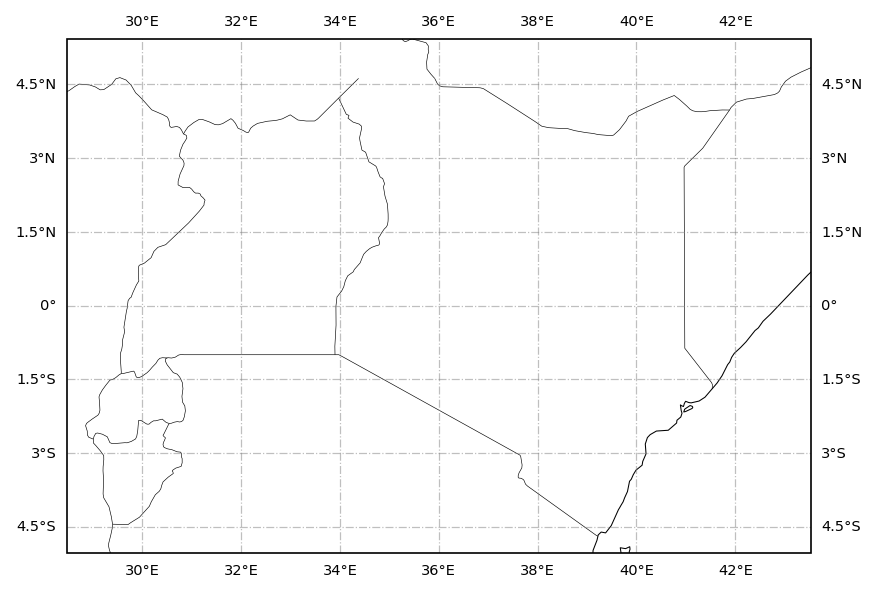

In [39]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# First we specify Coordinate Refference System for Map Projection
# We will use Mercator, which is a cylindrical, conformal projection. 
# It has bery large distortion at high latitudes, cannot 
# fully reach the polar regions.
projection = ccrs.Mercator()

# Specify CRS, that will be used to tell the code, where should our data be plotted
crs = ccrs.PlateCarree()

# Now we will create axes object having specific projection 
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}

# To plot borders and coastlines, we can use cartopy feature
import cartopy.feature as cf
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

# Now, we will specify extent of our map in minimum/maximum longitude/latitude
# Note that these values are specified in degrees of longitude and degrees of latitude
# However, we can specify them in any crs that we want, but we need to provide appropriate
# crs argument in ax.set_extent
lon_min = chirps["longitude"][0]
lon_max = chirps['longitude'][-1]
lat_min = chirps['latitude'][0]
lat_max = chirps['latitude'][-1]

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
# chirps["precip"].plot.contourf(ax=ax, transform=ccrs.PlateCarree())
# plt.title(f"Temperature anomaly over Europe in {original_data.valid_time.dt.strftime('%B %Y').values}")
plt.show()


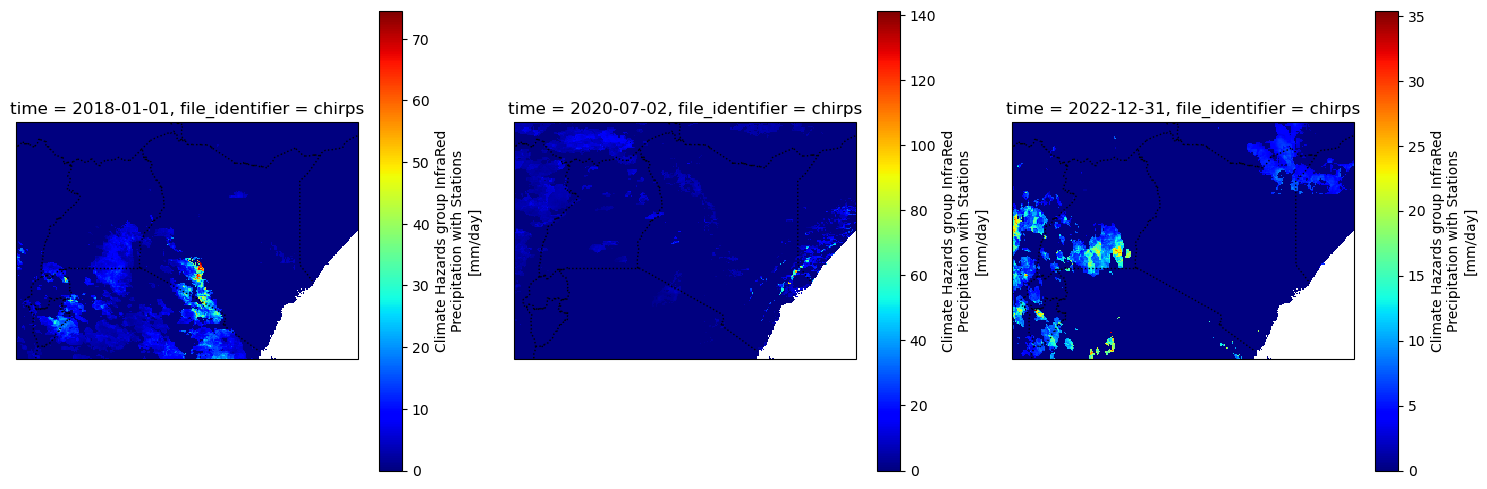

In [41]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Select the precipitation variable
precipitation = chirps['precip']

# Create a figure and axis with a PlateCarree projection
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop over three time steps (you can adjust this based on your preference)
for i, time_index in enumerate([0, len(precipitation.time) // 2, len(precipitation.time) - 1]):
    ax = axes[i]
    ax.set_title(f'Precipitation at time step {time_index}')
    
    # Plot precipitation data
    precipitation.isel(time=time_index).plot(ax=ax, cmap='jet', transform=ccrs.PlateCarree())
    
    lon_min = chirps["longitude"][0]
    lon_max = chirps['longitude'][-1]
    lat_min = chirps['latitude'][0]
    lat_max = chirps['latitude'][-1]

    # crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)

    # # Add coastlines and gridlines
    # ax.coastlines()
    # ax.gridlines(draw_labels=True)
    
    
    # Add country borders as reference
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
plt.tight_layout()
plt.show()

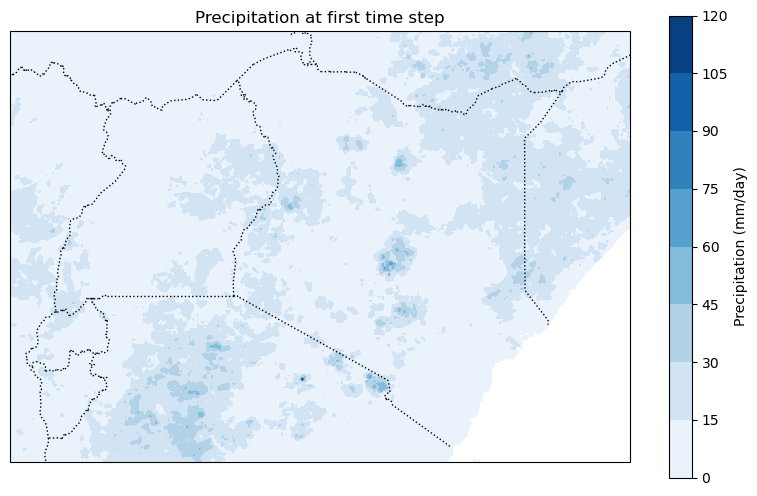

In [44]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select a specific time slice (e.g., the first time step)
precip_at_first_time_step = chirps['precip'][100]

# Create a map
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot precipitation
im = ax.contourf(precip_at_first_time_step['longitude'], 
                 precip_at_first_time_step['latitude'],
                 precip_at_first_time_step, 
                 transform=ccrs.PlateCarree(), 
                 cmap='Blues')

# Add coastlines and gridlines
# ax.coastlines()
# ax.gridlines(draw_labels=True)

lon_min = chirps["longitude"][0]
lon_max = chirps['longitude'][-1]
lat_min = chirps['latitude'][0]
lat_max = chirps['latitude'][-1]

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Precipitation (mm/day)')

# Show the plot
plt.title('Precipitation at first time step')
plt.show()


In [43]:
chirps['precip']

<xarray.DataArray 'precip' (time: 1826, latitude: 210, longitude: 302)> Size: 463MB
[115804920 values with dtype=float32]
Coordinates:
  * latitude         (latitude) float32 840B -5.025 -4.975 ... 5.375 5.425
  * longitude        (longitude) float32 1kB 28.47 28.52 28.57 ... 43.47 43.52
  * time             (time) datetime64[ns] 15kB 2018-01-01 ... 2022-12-31
    file_identifier  <U6 24B 'chirps'
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0